## Download LJSpeech

In [1]:
# !wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
# !tar -xjf LJSpeech-1.1.tar.bz2

In [2]:
# !pip install librosa

In [3]:
# !pip install torch==1.10.0+cu111 torchaudio==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

## Featurizer

In [4]:
from IPython import display
from dataclasses import dataclass

import torch
from torch import nn

import torchaudio

import librosa
from matplotlib import pyplot as plt


@dataclass
class MelSpectrogramConfig:
    sr: int = 22050
    win_length: int = 1024
    hop_length: int = 256
    n_fft: int = 1024
    f_min: int = 0
    f_max: int = 8000
    n_mels: int = 80
    power: float = 1.0

    # value of melspectrograms if we fed a silence into `MelSpectrogram`
    pad_value: float = -11.5129251


class MelSpectrogram(nn.Module):

    def __init__(self, config: MelSpectrogramConfig):
        super(MelSpectrogram, self).__init__()

        self.config = config

        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=config.sr,
            win_length=config.win_length,
            hop_length=config.hop_length,
            n_fft=config.n_fft,
            f_min=config.f_min,
            f_max=config.f_max,
            n_mels=config.n_mels
        )

        # The is no way to set power in constructor in 0.5.0 version.
        self.mel_spectrogram.spectrogram.power = config.power

        # Default `torchaudio` mel basis uses HTK formula. In order to be compatible with WaveGlow
        # we decided to use Slaney one instead (as well as `librosa` does by default).
        mel_basis = librosa.filters.mel(
            sr=config.sr,
            n_fft=config.n_fft,
            n_mels=config.n_mels,
            fmin=config.f_min,
            fmax=config.f_max
        ).T
        self.mel_spectrogram.mel_scale.fb.copy_(torch.tensor(mel_basis))

    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        """
        :param audio: Expected shape is [B, T]
        :return: Shape is [B, n_mels, T']
        """

        mel = self.mel_spectrogram(audio) \
            .clamp_(min=1e-5) \
            .log_()

        return mel

In [5]:
featurizer = MelSpectrogram(MelSpectrogramConfig())

---

## Dataset

In [6]:
class LJSpeechDataset(torchaudio.datasets.LJSPEECH):

    def __init__(self, root):
        super().__init__(root=root)
        self._tokenizer = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH.get_text_processor()

    def __getitem__(self, index: int):
        waveform, _, _, transcript = super().__getitem__(index)
        waveforn_length = torch.tensor([waveform.shape[-1]]).int()
        
        tokens, token_lengths = self._tokenizer(transcript)
        
        return waveform, waveforn_length, transcript, tokens, token_lengths
    
    def decode(self, tokens, lengths):
        result = []
        for tokens_, length in zip(tokens, lengths):
            text = "".join([
                self._tokenizer.tokens[token]
                for token in tokens_[:length]
            ])
            result.append(text)
        return result
                

In [7]:
dataset = LJSpeechDataset('.')

In [8]:
dataset[0]

(tensor([[-7.3242e-04, -7.6294e-04, -6.4087e-04,  ...,  7.3242e-04,
           2.1362e-04,  6.1035e-05]]),
 tensor([212893], dtype=torch.int32),
 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition',
 tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
          25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
          14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
          25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
          16, 29, 30, 11, 17, 29, 26, 24, 11, 24, 26, 30, 31, 11, 20, 17, 11, 25,
          26, 31, 11, 17, 29, 26, 24, 11, 12, 23, 23, 11, 31, 19, 16, 11, 12, 29,
          31, 30, 11, 12, 25, 15, 11, 14, 29, 12, 17, 31, 30, 11, 29, 16, 27, 29,
          16, 30, 16, 25, 31, 16, 15, 11, 20, 25, 11, 31, 19, 16, 11, 16, 35, 19,
          20, 13, 20, 31, 20, 26, 25]]),
 t

In [9]:
from typing import Tuple, Dict, Optional, List, Union
from itertools import islice

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


@dataclass
class Batch:
    waveform: torch.Tensor
    waveforn_length: torch.Tensor
    transcript: List[str]
    tokens: torch.Tensor
    token_lengths: torch.Tensor
    durations: Optional[torch.Tensor] = None
        
    def to(self, device: torch.device) -> 'Batch':
        raise NotImplementedError


class LJSpeechCollator:

    def __call__(self, instances: List[Tuple]) -> Dict:
        waveform, waveforn_length, transcript, tokens, token_lengths = list(
            zip(*instances)
        )

        waveform = pad_sequence([
            waveform_[0] for waveform_ in waveform
        ]).transpose(0, 1)
        waveforn_length = torch.cat(waveforn_length)

        tokens = pad_sequence([
            tokens_[0] for tokens_ in tokens
        ]).transpose(0, 1)
        token_lengths = torch.cat(token_lengths)

        return Batch(waveform, waveforn_length, transcript, tokens, token_lengths)

In [10]:
dataloader = DataLoader(LJSpeechDataset('.'), batch_size=3, collate_fn=LJSpeechCollator())

In [11]:
dummy_batch = list(islice(dataloader, 1))[0]
dummy_batch

Batch(waveform=tensor([[-0.0007, -0.0008, -0.0006,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0003,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0025, -0.0037,  0.0005,  ...,  0.0003,  0.0002, -0.0004]]), waveforn_length=tensor([212893,  41885, 213149], dtype=torch.int32), transcript=('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'in being comparatively modern.', 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'), tokens=tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
         25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
         14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
         25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
         16,

---

## Vocoder

In [12]:
!git clone https://github.com/NVIDIA/waveglow.git
!pip install googledrivedownloader

In [13]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [14]:
gdd.download_file_from_google_drive(
    file_id='1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF',
    dest_path='./waveglow_256channels_universal_v5.pt'
)

In [15]:
import warnings
import sys
sys.path.append('waveglow/')

warnings.filterwarnings('ignore')


class Vocoder(nn.Module):

    def __init__(self):
        super(Vocoder, self).__init__()

        model = torch.load('waveglow_256channels_universal_v5.pt', map_location='cpu')[
            'model']
        self.net = model.remove_weightnorm(model)

    @torch.no_grad()
    def inference(self, spect: torch.Tensor):
        spect = self.net.upsample(spect)

        # trim the conv artifacts
        time_cutoff = self.net.upsample.kernel_size[0] - \
            self.net.upsample.stride[0]
        spect = spect[:, :, :-time_cutoff]

        spect = spect.unfold(2, self.net.n_group, self.net.n_group) \
            .permute(0, 2, 1, 3) \
            .contiguous() \
            .flatten(start_dim=2) \
            .transpose(-1, -2)

        # generate prior
        audio = torch.randn(spect.size(0), self.net.n_remaining_channels, spect.size(-1)) \
            .to(spect.device)

        for k in reversed(range(self.net.n_flows)):
            n_half = int(audio.size(1) / 2)
            audio_0 = audio[:, :n_half, :]
            audio_1 = audio[:, n_half:, :]

            output = self.net.WN[k]((audio_0, spect))

            s = output[:, n_half:, :]
            b = output[:, :n_half, :]
            audio_1 = (audio_1 - b) / torch.exp(s)
            audio = torch.cat([audio_0, audio_1], 1)

            audio = self.net.convinv[k](audio, reverse=True)

            if k % self.net.n_early_every == 0 and k > 0:
                z = torch.randn(
                    spect.size(0), self.net.n_early_size, spect.size(2),
                    device=spect.device
                )
                audio = torch.cat((z, audio), 1)

        audio = audio.permute(0, 2, 1) \
            .contiguous() \
            .view(audio.size(0), -1)

        return audio

In [16]:
vocoder = Vocoder().to('cuda:0').eval()

In [17]:
waveform = dummy_batch.waveform[:1]
mels = featurizer(waveform).cuda()

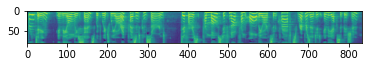

In [18]:
plt.imshow(mels[0].cpu())

In [19]:
reconstructed_wav = vocoder.inference(mels).cpu()

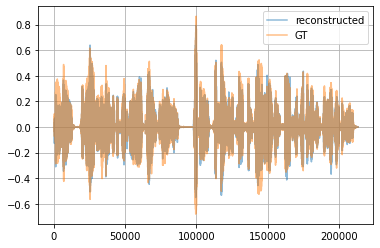

In [21]:
plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
plt.plot(waveform.squeeze(), label='GT', alpha=.5)
plt.grid()
plt.legend()
plt.show()

In [22]:
display.display(display.Audio(reconstructed_wav, rate=22050))
display.display(display.Audio(waveform, rate=22050))

---

## Grapheme Aligner

In [78]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


class GraphemeAligner(nn.Module):

    def __init__(self):
        super().__init__()

        self._wav2vec2 = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()
        self._labels = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_labels()
        self._char2index = {c: i for i, c in enumerate(self._labels)}
        self._unk_index = self._char2index['<unk>']

    def _decode_text(self, text):
        text = text.replace(' ', '|').upper()
        return torch.tensor([
            self._char2index.get(char, self._unk_index)
            for char in text
        ]).long()

    @torch.no_grad()
    def forward(
        self,
        wavs: torch.Tensor,
        wav_lengths: torch.Tensor,
        texts: Union[str, List[str]]
    ):
        if isinstance(texts, str):
            texts = [texts]
        batch_size = wavs.shape[0]

        durations = []
        for index in range(batch_size):
            emission, _ = self._wav2vec2(
                wavs[index, :wav_lengths[index]].unsqueeze(dim=0)
            )
            emission = emission.log_softmax(dim=-1).squeeze(dim=0).cpu()

            tokens = self._decode_text(texts[index])

            trellis = self._get_trellis(emission, tokens)
            path = self._backtrack(trellis, emission, tokens)
            segments = self._merge_repeats(texts[index], path)

            num_frames = emission.shape[0]
            relative_durations = torch.tensor([
                segment.length / num_frames for segment in segments
            ])

            durations.append(relative_durations)
            
        durations = pad_sequence(durations).transpose(0, 1)
        return durations

    def _get_trellis(self, emission, tokens, blank_id=0):
        num_frame = emission.size(0)
        num_tokens = len(tokens)

        # Trellis has extra dimension for both time axis and tokens.
        # The extra dim for tokens represents <SoS> (start-of-sentence)
        # The extra dim for time axis is for simplification of the code.
        trellis = torch.full((num_frame + 1, num_tokens + 1), -float('inf'))
        trellis[:, 0] = 0
        for t in range(num_frame):
            trellis[t + 1, 1:] = torch.maximum(
                # Score for staying at the same token
                trellis[t, 1:] + emission[t, blank_id],

                # Score for changing to the next token
                trellis[t, :-1] + emission[t, tokens],
            )
        return trellis

    def _backtrack(self, trellis, emission, tokens, blank_id=0):
        # Note:
        # j and t are indices for trellis, which has extra dimensions
        # for time and tokens at the beginning.
        # When refering to time frame index `T` in trellis,
        # the corresponding index in emission is `T-1`.
        # Similarly, when refering to token index `J` in trellis,
        # the corresponding index in transcript is `J-1`.
        j = trellis.size(1) - 1
        t_start = torch.argmax(trellis[:, j]).item()

        path = []
        for t in range(t_start, 0, -1):
            # 1. Figure out if the current position was stay or change
            # Note (again):
            # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
            # Score for token staying the same from time frame J-1 to T.
            stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
            # Score for token changing from C-1 at T-1 to J at T.
            changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

            # 2. Store the path with frame-wise probability.
            prob = emission[t - 1, tokens[j - 1]
                            if changed > stayed else 0].exp().item()
            # Return token index and time index in non-trellis coordinate.
            path.append(Point(j - 1, t - 1, prob))

            # 3. Update the token
            if changed > stayed:
                j -= 1
                if j == 0:
                    break

        else:
            raise ValueError('Failed to align')

        return path[::-1]

    def _merge_repeats(self, text, path):
        i1, i2 = 0, 0
        segments = []
        while i1 < len(path):
            while i2 < len(path) and path[i1].token_index == path[i2].token_index:
                i2 += 1
            score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
            segments.append(
                Segment(
                    text[path[i1].token_index],
                    path[i1].time_index,
                    path[i2 - 1].time_index + 1,
                    score
                )
            )
            i1 = i2

        return segments

    @staticmethod
    def plot_trellis_with_path(trellis, path):
        # to plot trellis with path, we take advantage of 'nan' value
        trellis_with_path = trellis.clone()
        for i, p in enumerate(path):
            trellis_with_path[p.time_index, p.token_index] = float('nan')
        plt.imshow(trellis_with_path[1:, 1:].T, origin='lower')

In [79]:
device = torch.device('cuda:0')
aligner = GraphemeAligner().to(device)

In [80]:
dummy_batch

Batch(waveform=tensor([[-0.0007, -0.0008, -0.0006,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0003,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0025, -0.0037,  0.0005,  ...,  0.0003,  0.0002, -0.0004]]), waveforn_length=tensor([212893,  41885, 213149], dtype=torch.int32), transcript=('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'in being comparatively modern.', 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'), tokens=tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
         25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
         14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
         25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
         16,

In [81]:
dummy_batch.durations = aligner(
    dummy_batch.waveform.to(device), dummy_batch.waveforn_length, dummy_batch.transcript
)

In [82]:
dummy_batch

Batch(waveform=tensor([[-0.0007, -0.0008, -0.0006,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0003,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0025, -0.0037,  0.0005,  ...,  0.0003,  0.0002, -0.0004]]), waveforn_length=tensor([212893,  41885, 213149], dtype=torch.int32), transcript=('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'in being comparatively modern.', 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'), tokens=tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
         25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
         14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
         25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
         16,

## Visualize

In [90]:
index = 0

waveform = dummy_batch.waveform[index][:dummy_batch.waveforn_length[index]]
durations = dummy_batch.durations[index][:dummy_batch.token_lengths[index]]

# scale by waveform domain
durations = durations * dummy_batch.waveforn_length[index]
durations = durations.cumsum(dim=0).int()

print(dummy_batch.transcript[index])
left = 0
for right, char in zip(durations[:10], dummy_batch.transcript[index]):
    print(char)
    display.display(display.Audio(waveform[left:right], rate=22050))
    left = right
    print('-' * 99)

Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
P


---------------------------------------------------------------------------------------------------
r


---------------------------------------------------------------------------------------------------
i


---------------------------------------------------------------------------------------------------
n


---------------------------------------------------------------------------------------------------
t


---------------------------------------------------------------------------------------------------
i


---------------------------------------------------------------------------------------------------
n


---------------------------------------------------------------------------------------------------
g


---------------------------------------------------------------------------------------------------
,


---------------------------------------------------------------------------------------------------
 


---------------------------------------------------------------------------------------------------


In [92]:
dummy_batch

Batch(waveform=tensor([[-0.0007, -0.0008, -0.0006,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0003,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0025, -0.0037,  0.0005,  ...,  0.0003,  0.0002, -0.0004]]), waveforn_length=tensor([212893,  41885, 213149], dtype=torch.int32), transcript=('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'in being comparatively modern.', 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'), tokens=tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
         25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
         14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
         25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
         16,